In [1]:
%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

## 6.1

In [2]:
boston = pd.read_csv('BostonHousing.csv')
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4,0
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6,0
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9,0
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0,0


#### a

In [3]:
## 학습세트와 검증 세트로 나누는 이유

새로운 사례를 예측하는 것이 목적인 모델에서 데이터는 일반적으로 학습 세트와 검증 세트로 나눠진다.  
데이터마이닝, 즉 예측 모델링을 할 때에는 데이터를 모델에 잘 적합시키는 것이 목표가 아니라 새로운 사례를 잘 예측시키는 것이 목적이기 때문에 학습세트가 아닌 검증세트로 예측 성능을 평가하는 과정이 있어야한다

In [4]:
## 학습 세트와 검증 세트는 어떤 용도로 사용

학습 세트는 모델을 추정하는데 사용되며, 모델 구축하고 학습할 때 사용된다. 
검증세트는 학습 세트로부터 구축된 여러 모델 성능을 비교할때 즉, 이전에 관측되지 않았던 새로운 데이터에 대한 모델의 예측 성능을 평가하는데 사용된다.

In [5]:
## CRIM  CHAs  RM 은 독립변수 / MEDV 종속변수 - 다중선형회귀모델
predictors = ["CRIM", "CHAS", "RM"]
outcome = "MEDV"

X = pd.get_dummies(boston[predictors], drop_first=True)
Y = boston[outcome]

train_X, vaild_X, train_Y, vaild_Y = train_test_split(X, Y, test_size=0.4, random_state=1) 
#테스트 사이즈를 예시보고 임의적으로 넣음 - 학습과 검증 데이터를 나누는 과정

In [6]:
boston_lm = LinearRegression()
boston_lm.fit(train_X, train_Y)

print("Intercept", boston_lm.intercept_)
print()
print(pd.DataFrame({'Preditior': X.columns, 'coefficient': boston_lm.coef_})) # 계수 print

Intercept -29.19346743060684

  Preditior  coefficient
0      CRIM    -0.240062
1      CHAS     3.266817
2        RM     8.325175


#### b

In [7]:
## 모델의 예측 변수들로부터 주택가격 중앙값을 예측하기 위한 식 작성

In [8]:
inter = round(boston_lm.intercept_,3)
p_crim=round(boston_lm.coef_[0],3)
p_chas=round(boston_lm.coef_[1],3)
p_rm=round(boston_lm.coef_[2],3)

print("\n p_MEDV = ",inter, "+", p_crim,"*crim +", p_chas, "*chas+", p_rm,"*rm")


 p_MEDV =  -29.193 + -0.24 *crim + 3.267 *chas+ 8.325 *rm


#### c

In [9]:
## Chas = 0, Crim = 0.1, Rm = 6 의 MEDV의 예측값과 예측오차는? 

In [10]:
boston_pred = boston_lm.predict([[0.1, 0, 6]])
print("Predicted: ", boston_pred)

# 식에 직접 대입해서 구한 값 - 동일하게 나옴
p_MEDV =  -29.193 + -0.24*0.1 + 3.267*0+ 8.325*6
print("예측값: ", p_MEDV)

Predicted:  [20.73357813]
예측값:  20.732999999999993


In [11]:
#실제값 구하는 방법
b3=boston[boston['CHAS'] == 0]
real_MEDV = float(b3[b3["CRIM"] == 0.1]['MEDV'].values)
                  
print("실제값: ", real_MEDV)
print("예측오차: ", real_MEDV-boston_pred) 

실제값:  33.1
예측오차:  [12.36642187]


#### d

In [12]:
## 예측변수의 수를 감소하시오.

##### 1

In [13]:
## 어떠한 예측변수들이 동일한 것을 측정할 것 같은가?
## INDUS, NOX, TAX 간의 관계에 대해 논하시오.

INDUS는 시별 비상업지역의 비율, NOX는 10ppm당 일산화질소이다. INDUS가 낮을수록, 즉 비상업지역의 비율이 낮을수록 상업지역의 비율이 높다는 것이고 NOX 일산화질소는 높을 것 같다.
또한 TAX는 주택가격에 영향을 받기 때문에 주택가격을 예측하는 회귀분석에서 좋은 예측변수가 되지 못할 것이다.


##### 2

In [14]:
boston2=boston.drop(["MEDV","CAT. MEDV"], axis=1) 
## 12개의 수치형 예측 변수들이라 했으니 이 중 하나는 범주형 변수 - CAT.MEDV

In [15]:
##상관관계 표 계산

In [16]:
corr=boston2.corr(method="pearson")

In [17]:
import matplotlib.pyplot as plt 
import seaborn as sns

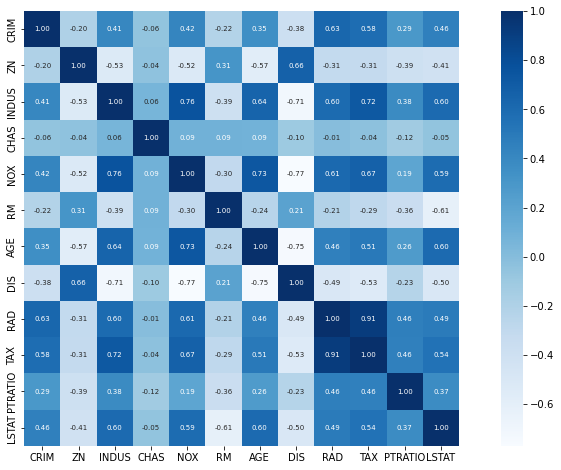

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
df_heatmap = sns.heatmap(corr, cbar = True, 
                         annot = True, annot_kws={'size' : 7}, 
                         fmt = '.2f', square = True, cmap = 'Blues')

In [19]:
# 높은 상관관계를 갖는 변수의 쌍 찾기

0.91로 RAD와 TAX가 높은 상관관계를 갖는다. 따라서 둘 중 하나 제거하는데, 이 변수의 쌍은 잠재적으로 중복성을 갖고 다중공선성의 원인이 될 수 있기 때문에 제거하는 것이 좋다.

##### 3

In [20]:
predictors = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'PTRATIO', 'LSTAT'] ## 높은 상관관계 갖는 RAD 와 TAX 제외
outcome = 'MEDV' 

# partition data
X = pd.get_dummies(boston[predictors], drop_first=True)
y = boston[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

boston_lm = LinearRegression()
boston_lm.fit(train_X, train_y)

LinearRegression()

In [21]:
## 나머지 예측변수들을 감소시키기 위해 후방소거법
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, PTRATIO, LSTAT
Start: score=1813.94
Step: score=1811.94, remove AGE
Step: score=1810.16, remove INDUS
Step: score=1810.16, remove None
['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']


후방 소거법을 통해 ZN, AGE, None 을 제거하고 'CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT' 의 변수를 포함하여 만든 모형

In [22]:
## 나머지 예측변수들을 감소시키기 위해 전방선택방법
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, PTRATIO, LSTAT
Start: score=2191.75, constant
Step: score=1934.91, add LSTAT
Step: score=1874.18, add RM
Step: score=1842.54, add PTRATIO
Step: score=1837.69, add CHAS
Step: score=1835.00, add NOX
Step: score=1817.90, add DIS
Step: score=1811.82, add ZN
Step: score=1810.16, add CRIM
Step: score=1810.16, add None
['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM']


전방 소거법을 통해'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM'의 변수로 만들어진 최적의 모형을 얻음

In [23]:
# 나머지 예측변수들을 감소시키기 위해 단계적 선택방법
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, PTRATIO, LSTAT
Start: score=2191.75, constant
Step: score=1934.91, add LSTAT
Step: score=1874.18, add RM
Step: score=1842.54, add PTRATIO
Step: score=1837.69, add CHAS
Step: score=1835.00, add NOX
Step: score=1817.90, add DIS
Step: score=1811.82, add ZN
Step: score=1810.16, add CRIM
Step: score=1810.16, unchanged None
['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM']


단계 선택방법을 통해 'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM'를 포함하여 최적의 모형을 만든다.

In [24]:
# [첫째] 성능이 좋은 상위 3개 모델 선택

단계, 후방, 전방 :  'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM' 동일한 모형을 얻을 수 있다.

In [25]:
# [둘째] 학습 세트에 대해 각각 구축한 후 검증 세트에 대해 예측 정확도 비교

In [26]:
predictors = [ 'LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM' ]
outcome = "MEDV"

X = pd.get_dummies(boston[predictors], drop_first=True)
y = boston[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1) 

boston_lm = LinearRegression()
boston_lm.fit(train_X, train_y)

LinearRegression()

In [27]:
pred_y = boston_lm.predict(valid_X)
print('adjusted r2 : ', adjusted_r2_score(valid_y, pred_y, boston_lm)) 
print('AIC : ', AIC_score(valid_y, pred_y, boston_lm))
print('BIC : ', BIC_score(valid_y, pred_y, boston_lm)) 

adjusted r2 :  0.6916811808962059
AIC :  1263.197413756775
BIC :  1296.3294735471927


In [28]:
# [셋째] RMSE, 평균오차, 리프트 도표 사용하여 비교

In [29]:
pred_y = boston_lm.predict(valid_X)
regressionSummary(valid_y, pred_y)


Regression statistics

                      Mean Error (ME) : -0.0397
       Root Mean Squared Error (RMSE) : 5.1713
            Mean Absolute Error (MAE) : 3.6519
          Mean Percentage Error (MPE) : -5.2055
Mean Absolute Percentage Error (MAPE) : 17.1988


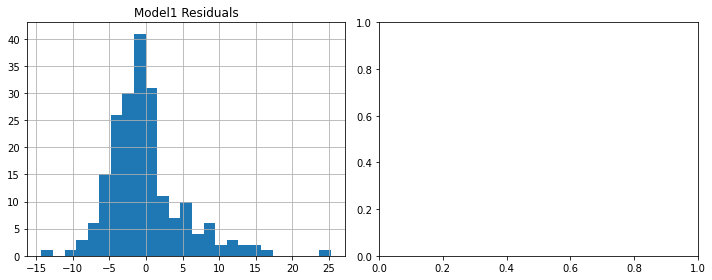

In [30]:
all_residuals1 = valid_y -pred_y
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax = pd.DataFrame({"Model1 Residuals": all_residuals1}).hist(bins=25, ax=axes[0])
plt.tight_layout()
plt.show()

In [31]:
# [넷째] 가장 좋은 모형을 선택 후 이에 대해 기술

## 6.2

In [32]:
tay=pd.read_csv('Tayko.csv')
tay.columns

Index(['sequence_number', 'US', 'source_a', 'source_c', 'source_b', 'source_d',
       'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s',
       'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq',
       'last_update_days_ago', '1st_update_days_ago', 'Web order',
       'Gender=male', 'Address_is_res', 'Purchase', 'Spending'],
      dtype='object')

In [33]:
tay.head(5)

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,128
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0


In [34]:
tay=tay[['US', 'Address_is_res', 'Gender=male', 'Web order', 'last_update_days_ago', 'Freq','Spending']]

#### a

In [35]:
tay_class=tay[['US', 'Address_is_res', 'Gender=male', 'Web order', 'Spending']]
tay_class.drop(['Spending'], axis = 1)

,US,Address_is_res,Gender=male,Web order
0,1,1,0,1
1,1,0,1,1
2,1,0,0,0
3,1,0,1,0
4,1,0,0,0
...,...,...,...,...
1995,1,0,0,1
1996,1,0,1,1
1997,1,0,0,0
1998,1,1,1,0


In [36]:
us_1=tay_class[tay_class['US']==1].Spending.describe()
us_0=tay_class[tay_class['US']==0].Spending.describe()

add_1=tay_class[tay_class['Address_is_res']==1].Spending.describe()
add_0=tay_class[tay_class['Address_is_res']==0].Spending.describe()

gender_1=tay_class[tay_class['Gender=male']==1].Spending.describe()
gender_0=tay_class[tay_class['Gender=male']==0].Spending.describe()

web_1=tay_class[tay_class['Web order']==1].Spending.describe()
web_0=tay_class[tay_class['Web order']==0].Spending.describe()

In [37]:
data={'us_1':us_1, 'us_0':us_0,
      'add_1':add_1, 'add_0':add_0,
      'gender_1':gender_1, 'gender_0':gender_0,
      'web_1':web_1, 'web_0':web_0           
     }

data2={'mean':pd.DataFrame(data).mean(), 'std':pd.DataFrame(data).std()}
pd.DataFrame(data2)


,mean,std
us_1,449.775058,698.928156
us_0,278.882616,484.747687
add_1,183.734811,234.639178
add_0,438.978415,677.057361
gender_1,372.046359,574.150090
gender_0,357.771497,539.349506
web_1,357.176671,517.700987
web_0,379.289941,594.121612


In [38]:
carr=tay_class.drop(columns=["FREQ","LAST_UPDATE","SPENDING"])

print(raw_df.groupby(list(carr.columns)).mean().SPENDING)#평균
print(raw_df.groupby(list(carr.columns)).std().SPENDING)#표준편차

KeyError: "['FREQ' 'LAST_UPDATE' 'SPENDING'] not found in axis"

#### b

In [ ]:
import matplotlib.pyplot as plt

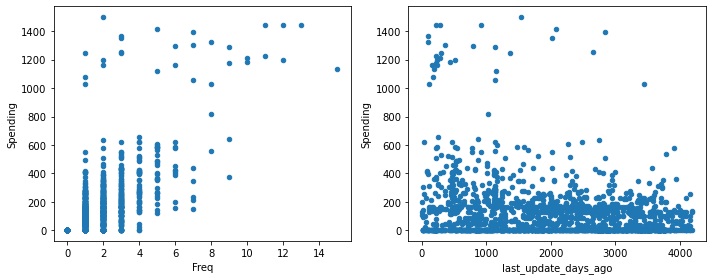

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

ax = tay.plot.scatter(x='Freq', y='Spending', legend=False, ax=axes[0])
ax = tay.plot.scatter(x='last_update_days_ago', y='Spending', legend=False, ax=axes[1])

plt.tight_layout()
plt.show()

두 변수 모두 선형관계가 보이지 않는다.

#### c

##### 1

In [40]:
predictors = ['US', # 미국 주소지인지에 대한 여부
              'Freq', # 전년도 거래일수
       'last_update_days_ago', # 최종갱신일로부터 경과일수
              'Web order', #고객이 인터넷 구매 여부
       'Gender=male', #성별
              'Address_is_res'] #거주지 주소인지에 대한 여부
outcome = 'Spending'

X = pd.get_dummies(tay[predictors], drop_first=True)
y = tay[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

##### 2

In [41]:
tay_lm = LinearRegression()
tay_lm.fit(train_X, train_y)

print("Intercept", round(tay_lm.intercept_,3))
print()
print(pd.DataFrame({'Preditior': X.columns, 'coefficient': tay_lm.coef_}))

Intercept 10.176

              Preditior  coefficient
0                    US    -4.620293
1                  Freq    91.274450
2  last_update_days_ago    -0.010374
3             Web order    18.628731
4           Gender=male    -9.111366
5        Address_is_res   -75.815354


선형회귀식 모형 : y = 10.176 - 4.62x1 + 91.274x2 - 0.01x3 + 18.629x4 - 9.111x5 - 75.815x6



x1 US 
x2 Freq 
x3 last_update_days_ago 
x4 Web order 
x5 Gender 
x6 Address_is_res 

##### 3

 위의 선형회귀식 모형의 부호를 통해 알 수 있다.
미국에 거주하지 않고
전년도 거래일수가 많고
최종갱신일로부터 경과일수가 작고
인터넷 구매여부가 있고
성별이 여자이고
거주지 주소가 아닌 고객이 가장 많은 돈을 지출한다.

##### 4

In [42]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: US, Freq, last_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=15028.53
Step: score=15026.76, remove US
Step: score=15026.38, remove Gender=male
Step: score=15026.38, remove None
['Freq', 'last_update_days_ago', 'Web order', 'Address_is_res']


제일 처음으로 US 미국 주소인지 여부를 알려주는 변수가 탈락한다.

##### 5

In [43]:
valid_X.head(1) # x값

,US,Freq,last_update_days_ago,Web order,Gender=male,Address_is_res
674,1,2,1346,0,1,1


In [44]:
valid_y.head(1) # y값

674    0
Name: Spending, dtype: int64

In [45]:
y = 10.176 - 4.62*1 + 91.274*2 - 0.01*1346 + 18.629*0 - 9.111*1 - 75.815 * 1 
print('예측값: ', y)
print('실제값: ', 0)
print('예측오차: ', 0-y)

예측값:  89.71800000000002
실제값:  0
예측오차:  -89.71800000000002


##### 6

In [46]:
pred_y = tay_lm.predict(valid_X)
regressionSummary(valid_y, pred_y) # 검증 세트에 대한 성능 파악


Regression statistics

               Mean Error (ME) : 7.1933
Root Mean Squared Error (RMSE) : 136.7397
     Mean Absolute Error (MAE) : 83.6010


In [47]:
print('adjusted r2 : ', adjusted_r2_score(valid_y, pred_y, tay_lm)) 
print('AIC : ', AIC_score(valid_y, pred_y, tay_lm))
print('BIC : ', BIC_score(valid_y, pred_y, tay_lm)) 

## 값이 클수록 좋은 적합성을 보이는 것으로 알고 있으나 1과 0중 0에 더 가까운 값으로 정확도가 좋다고 보기 어렵다.

adjusted r2 :  0.4915759673170541
AIC :  10155.227820697535
BIC :  10192.704714518879


##### 7

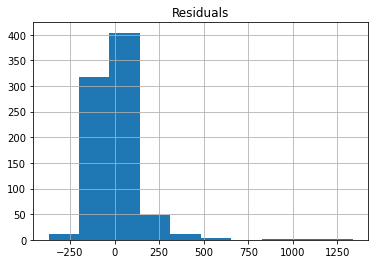

In [48]:
tay_residuals = valid_y - pred_y
ax = pd.DataFrame({"Residuals":tay_residuals}).hist()

plt.show()

## 6.3

In [49]:
air = pd.read_csv('Airfares.csv')
air.head(10)

,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,*,Dallas/Fort Worth TX,*,Amarillo TX,1.00,3,No,Yes,5291.99,28637.0,21112.0,3036732,205711,Free,Free,312,7864,64.11
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,26993.0,29838.0,3532657,7145897,Free,Free,576,8820,174.47
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,30124.0,29838.0,5787293,7145897,Free,Free,364,6452,207.76
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Controlled,Free,612,25144,85.47
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Free,Free,612,25144,85.47
5,*,Cleveland OH,*,Baltimore/Wash Intl MD,1.01,3,No,Yes,3408.11,26046.0,29838.0,2230955,7145897,Free,Free,309,13386,56.76
6,*,Dallas/Fort Worth TX,*,Baltimore/Wash Intl MD,1.28,3,No,No,6754.48,28637.0,29838.0,3036732,7145897,Free,Free,1220,4625,228.00
7,*,Fort Lauderdale FL,*,Baltimore/Wash Intl MD,1.15,3,Yes,Yes,5584.00,26752.0,29838.0,1440377,7145897,Free,Free,921,5512,116.54
8,*,Houston TX,*,Baltimore/Wash Intl MD,1.33,3,No,Yes,4662.44,27211.0,29838.0,3770125,7145897,Free,Free,1249,7811,172.63
9,*,Kansas City MO,*,Baltimore/Wash Intl MD,1.60,2,No,Yes,2617.00,25450.0,29838.0,1694803,7145897,Free,Free,964,4657,114.76


In [50]:
air.dtypes

S_CODE       object
S_CITY       object
E_CODE       object
E_CITY       object
COUPON      float64
NEW           int64
VACATION     object
SW           object
HI          float64
S_INCOME    float64
E_INCOME    float64
S_POP         int64
E_POP         int64
SLOT         object
GATE         object
DISTANCE      int64
PAX           int64
FARE        float64
dtype: object

#### a

In [51]:
air_num = air[['COUPON','NEW','HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'DISTANCE', 'PAX', 'FARE']] # 수치형변수

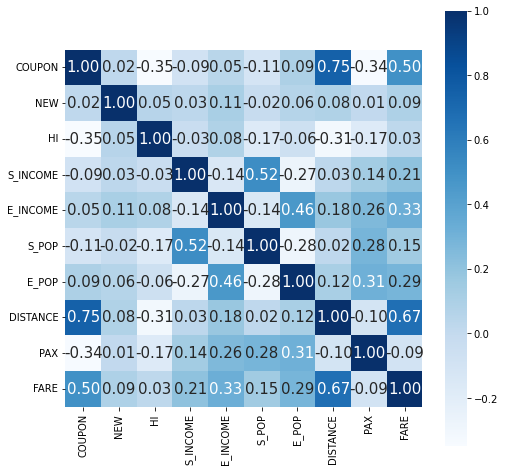

In [52]:
## 운임에 대한 상관관계 표
corr = air_num.corr(method="pearson")

import seaborn as sns

fig, ax= plt.subplots()
fig.set_size_inches(8,8)

df_heatmap = sns.heatmap(corr, cbar = True, 
                         annot = True, annot_kws={'size' : 15}, 
                         fmt = '.2f', square = True, cmap = 'Blues')

In [53]:
##운임과 예측변수들 사이의 산점도 그리기

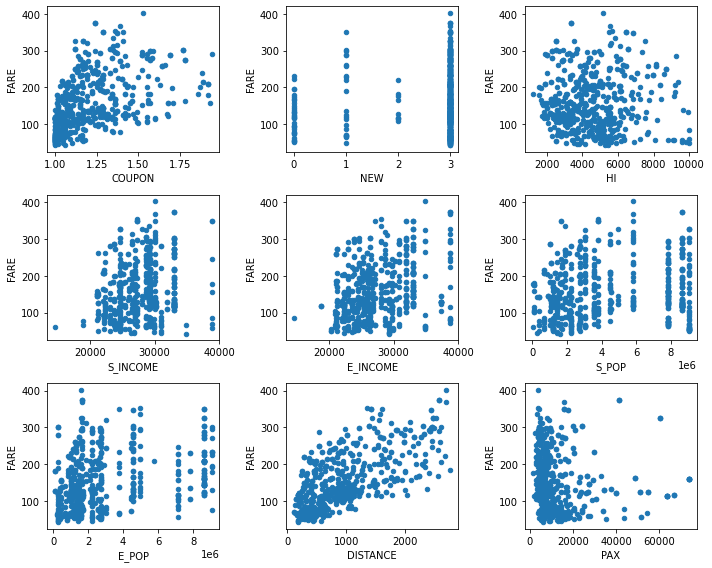

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,8))
lst =[['COUPON', 'NEW', 'HI'], ['S_INCOME', 'E_INCOME', 'S_POP'], ['E_POP', 'DISTANCE', 'PAX']]
for i in range(0,3):
    for j in range(0,3):
        ax = air_num.plot.scatter(x=lst[i][j], y='FARE', ax=axes[i][j])
        ax.set_xlabel(lst[i][j])
        if i == 2 and j == 2:
            break
plt.tight_layout()
plt.show()

distance가 운임을 예측하는데에 최적의 변수로 보인다.

#### b

In [55]:
air_class = air[['VACATION', 'SW', 'SLOT', 'GATE', 'FARE']]
print('vacation 사이즈> \n\n' ,air_class.groupby('VACATION').size(), '\n')
print('sw 사이즈> \n\n' ,air_class.groupby('SW').size(), '\n')
print('slot 사이즈> \n\n' ,air_class.groupby('SLOT').size(), '\n')
print('gate 사이즈> \n\n' ,air_class.groupby('GATE').size())

vacation 사이즈> 

 VACATION
No     468
Yes    170
dtype: int64 

sw 사이즈> 

 SW
No     444
Yes    194
dtype: int64 

slot 사이즈> 

 SLOT
Controlled    182
Free          456
dtype: int64 

gate 사이즈> 

 GATE
Constrained    124
Free           514
dtype: int64


In [56]:
vacation_no=air_class[air_class['VACATION']=='No'].FARE.mean()
vacation_yes=air_class[air_class['VACATION']=='Yes'].FARE.mean()

sw_no=air_class[air_class['SW']=='No'].FARE.mean()
sw_yes=air_class[air_class['SW']=='Yes'].FARE.mean()

slot_con=air_class[air_class['SLOT']=='Controlled'].FARE.mean()
slot_free=air_class[air_class['SLOT']=='Free'].FARE.mean()


gate_con=air_class[air_class['GATE']=='Constrained'].FARE.mean()
gate_free=air_class[air_class['GATE']=='Free'].FARE.mean()

In [57]:
data = {'vacation_no': [468/638,vacation_no], 
        'vacation_yes':[(170/638),vacation_yes],
        'sw_no':[444/638,sw_no],
        'sw_yes':[(638-444)/638,sw_yes],
        'slot_con':[182/638,slot_con],
        'slot_free':[456/638,slot_free],
        'gate_con':[124/638,gate_con],
        'gate_free':[514/638,gate_free]
       }
df = pd.DataFrame(data)
df # 첫 행은 각각의 백분율 , 두번째 행은 평균 운임을 보여줌

,vacation_no,vacation_yes,sw_no,sw_yes,slot_con,slot_free,gate_con,gate_free
0,0.733542,0.266458,0.695925,0.304075,0.285266,0.714734,0.194357,0.805643
1,173.552500,125.980882,188.182793,98.382268,186.059396,150.825680,193.129032,153.095953


SW 변수가 범주 다른 것에 따라 운임료 차이가 가장 많이나는 것을 보아서 운임을 예측하는데 가장 좋은 예측변수인 것 같다.

In [59]:
####### 다른 방법으로 평균과 백분율 구하기

b_df=air_class[["VACATION","SW","SLOT","GATE","FARE"]]
lst=["VACATION","SW","SLOT","GATE"]
for i in lst:
    print(b_df.groupby(i).mean())

                FARE
VACATION            
No        173.552500
Yes       125.980882
           FARE
SW             
No   188.182793
Yes   98.382268
                  FARE
SLOT                  
Controlled  186.059396
Free        150.825680
                   FARE
GATE                   
Constrained  193.129032
Free         153.095953


#### c

##### 1

In [60]:
predictors= ['COUPON', 'NEW', 'VACATION', 'SW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE', 'DISTANCE', 'PAX']
outcome='FARE'

X = pd.get_dummies(air[predictors], drop_first=True) # 범주형 변수 가변수로 변환
y = air[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1) # 학습세트와 검증세트로 분할 
air_lm = LinearRegression()
air_lm.fit(train_X, train_y) #학습세트에 대해 모델 적합

LinearRegression()

In [61]:
# 검증세트에 대해 평가
air_pred = air_lm.predict(valid_X)

print("adjusted r2 :", adjusted_r2_score(valid_y, air_pred, air_lm))
print("AIC :", AIC_score(valid_y, air_pred, air_lm))
print("BIC :", BIC_score(valid_y, air_pred, air_lm))

adjusted r2 : 0.7777314391756964
AIC : 2591.261260459084
BIC : 2644.4389221262772


##### 2

In [62]:
## 예측변수를 줄이기 위해 단계적 회귀
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

In [63]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: COUPON, NEW, HI, S_INCOME, E_INCOME, S_POP, E_POP, DISTANCE, PAX, VACATION_Yes, SW_Yes, SLOT_Free, GATE_Free
Start: score=4379.42, constant
Step: score=4149.88, add DISTANCE
Step: score=4025.89, add SW_Yes
Step: score=3913.59, add VACATION_Yes
Step: score=3890.27, add HI
Step: score=3873.33, add GATE_Free
Step: score=3852.81, add SLOT_Free
Step: score=3850.30, add PAX
Step: score=3844.58, add E_POP
Step: score=3826.43, add S_POP
Step: score=3821.88, add E_INCOME
Step: score=3821.88, unchanged None
['DISTANCE', 'SW_Yes', 'VACATION_Yes', 'HI', 'GATE_Free', 'SLOT_Free', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']


##### 3

In [64]:
## 전역탐색 
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj          AIC  COUPON  DISTANCE  E_INCOME  E_POP  GATE_Free     HI    NEW    PAX  \
0    1  0.453107  4149.881509   False      True     False  False      False  False  False  False   
1    2  0.605715  4025.892420   False      True     False  False      False  False  False  False   
2    3  0.706909  3913.585125   False      True     False  False      False  False  False  False   
3    4  0.724977  3890.268211   False      True     False  False      False   True  False  False   
4    5  0.737584  3873.328296   False      True     False  False       True   True  False  False   
5    6  0.751947  3852.808698   False      True     False  False       True   True  False  False   
6    7  0.758747  3843.170960   False      True     False   True      False   True  False   True   
7    8  0.765105  3833.945866   False      True     False   True       True   True  False   True   
8    9  0.770266  3826.433471   False      True     False   True       True   True  False   True   


r^2의 값이 증가하다가 안정된 형태가 되는 순간이며 단계적으로 얻은 것과 동일함

##### 4

In [65]:
airfare_pred = model.predict(valid_X) 
regressionSummary(valid_y, airfare_pred) #RMSE와 평균오차를 얻음


Regression statistics

                      Mean Error (ME) : -1.8231
       Root Mean Squared Error (RMSE) : 36.0002
            Mean Absolute Error (MAE) : 28.5002
          Mean Percentage Error (MPE) : -6.6037
Mean Absolute Percentage Error (MAPE) : 21.6048


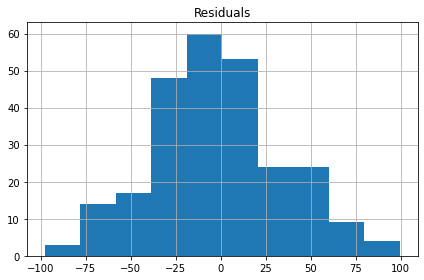

In [66]:
airfare_residuals = valid_y - airfare_pred

ax = pd.DataFrame({"Residuals":airfare_residuals}).hist() #잔차히스토그램 얻음
plt.tight_layout()
plt.show()

##### 5

In [67]:
airfare_pred3 = model.predict([[1202, 3, 0, 0, 4442.141, 28760, 27644, 4557004, 3195503, 1, 1, 12782, 1976 ]])
print("Predicted: ", airfare_pred3)

Predicted:  [122720.139013]


##### 6

In [68]:
print('intercept ', model.intercept_)
print()
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': model.coef_}))

intercept  52.97284313801684

       Predictor  coefficient
0         COUPON   -11.744039
1            NEW    -2.508229
2             HI     0.006876
3       S_INCOME     0.000626
4       E_INCOME     0.001247
5          S_POP     0.000004
6          E_POP     0.000004
7       DISTANCE     0.077822
8            PAX    -0.000916
9   VACATION_Yes   -35.206099
10        SW_Yes   -42.157140
11     SLOT_Free   -13.533183
12     GATE_Free   -21.185849


SW_Yes의 회귀계수는 -42.157

따라서 사우스웨스트사가 이 노선을 운행할 때 SW_Yes=1이며 이 노선의 평균 운임 감소율은 -42.157만큼 감소한다.

##### 7

PAX: 신규공항이므로 해당 노선 승객수 측정 x
HI: 신규공항이므로 시장 점유율 측정 x
비슷한 규모, 도시의 공항들과 비슷한 노선들을 연구해서 예측하거나 중앙값으로 대체해서 예측
혹은 정확한 평균 운임을 예측하기 위해 제외하고 분석한다.

##### 8

In [69]:
predictors_new= ['COUPON', 'NEW', 'VACATION', 'SW', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE', 'DISTANCE']
outcome=['FARE']
X = pd.get_dummies(air[predictors_new], drop_first=True)
y = air[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression()

In [70]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

In [71]:
allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

In [72]:
data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj          AIC  COUPON  DISTANCE  E_INCOME  E_POP  GATE_Free    NEW  SLOT_Free  \
0    1  0.453107  4149.881509   False      True     False  False      False  False      False   
1    2  0.606753  4023.892420   False      True     False  False      False  False      False   
2    3  0.708452  3909.585125   False      True     False  False      False  False      False   
3    4  0.722611  3890.568278   False      True     False  False       True  False      False   
4    5  0.730178  3880.002676   False      True     False  False       True  False       True   
5    6  0.735468  3872.437877   False      True      True  False       True  False       True   
6    7  0.736180  3871.409559   False      True      True  False       True  False       True   
7    8  0.737322  3869.751454   False      True      True   True       True  False       True   
8    9  0.737476  3869.527665   False      True      True   True       True   True       True   
9   10  0.737535  3869.442315 

##### 9

In [73]:
airfare_p = model.predict([[1202, 3, 0, 0, 28760, 27644, 4557004, 3195503, 1, 1, 1976 ]])
print("Predicted: ", airfare_p)

Predicted:  [[-1.47915671e+08]]


##### 10

In [74]:
airfare_pred_new = model.predict(valid_X)
regressionSummary(valid_y, airfare_pred_new)


Regression statistics

                      Mean Error (ME) : -0.6760
       Root Mean Squared Error (RMSE) : 40.1840
            Mean Absolute Error (MAE) : 32.0136
          Mean Percentage Error (MPE) : -6.9218
Mean Absolute Percentage Error (MAPE) : 23.5013


In [75]:
airfare_pred_new = model.predict(valid_X)
print("adjusted r2 :", adjusted_r2_score(valid_y, airfare_pred_new, model))
print("AIC :", AIC_score(valid_y, airfare_pred_new, model))
print("BIC :", BIC_score(valid_y, airfare_pred_new, model))

adjusted r2 : 0.7361507541696652
AIC : 2623.552603359547
BIC : 2634.1881356929857


#### d

데이터 분할을 할 필요가 없다.

## 6.4

In [76]:
toyota = pd.read_csv('ToyotaCorolla.csv')

In [77]:
toyota = toyota.copy()
toyota = pd.get_dummies(toyota, columns=["Fuel_Type"], prefix_sep='_', drop_first = True) 
## Fuel_Type object라 가변수로 변환 뒤 적용

In [78]:
toyota.dtypes

Id                    int64
Model                object
Price                 int64
Age_08_04             int64
Mfg_Month             int64
Mfg_Year              int64
KM                    int64
HP                    int64
Met_Color             int64
Color                object
Automatic             int64
CC                    int64
Doors                 int64
Cylinders             int64
Gears                 int64
Quarterly_Tax         int64
Weight                int64
Mfr_Guarantee         int64
BOVAG_Guarantee       int64
Guarantee_Period      int64
ABS                   int64
Airbag_1              int64
Airbag_2              int64
Airco                 int64
Automatic_airco       int64
Boardcomputer         int64
CD_Player             int64
Central_Lock          int64
Powered_Windows       int64
Power_Steering        int64
Radio                 int64
Mistlamps             int64
Sport_Model           int64
Backseat_Divider      int64
Metallic_Rim          int64
Radio_cassette      

In [79]:
predictors = ['Age_08_04',  'KM', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'HP', 'Automatic', 'Doors',
             'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 'Airco', 'Automatic_airco', 'CD_Player', 
              'Powered_Windows', 'Sport_Model', 'Tow_Bar']
outcome = "Price"

X = pd.get_dummies(toyota[predictors], drop_first=True)
y = toyota[outcome]

#### a

In [80]:
# train:valid:test = 6:2;2로 나눔
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)
# X랑 y를 train: test=8:2로 나눔
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.25, random_state=1)
# 8에 해당하는 train을 또 train:valid=3:1 (0.75:0.25)로 나눠지고 이후 6:2로 나눠지게 됨

model=LinearRegression()
model.fit(train_X, train_y)

print("intercept : ", model.intercept_)
print(pd.DataFrame({"Predictors": X.columns, "Coefficient": model.coef_}))

intercept :  8285.39834941601
          Predictors  Coefficient
0          Age_08_04  -111.220280
1                 KM    -0.016265
2   Fuel_Type_Diesel  2313.076450
3   Fuel_Type_Petrol  3145.575719
4                 HP    32.069859
5          Automatic   536.593712
6              Doors   130.936305
7      Quarterly_Tax    21.689746
8      Mfr_Guarantee   216.361361
9   Guarantee_Period    91.314854
10             Airco    62.256902
11   Automatic_airco  3184.704838
12         CD_Player   247.676882
13   Powered_Windows   492.718042
14       Sport_Model   349.905657
15           Tow_Bar  -180.733479


In [81]:
## 가장 중요한 변수를 찾기위해 전역탐색 이용
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

In [82]:
allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

In [83]:
data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj           AIC  Age_08_04  Airco  Automatic  Automatic_airco  CD_Player  Doors  \
0    1  0.761855  15312.342479       True  False      False            False      False  False   
1    2  0.817745  15083.046574       True  False      False             True      False  False   
2    3  0.841174  14965.571840       True  False      False             True      False  False   
3    4  0.850247  14915.917776       True  False      False             True      False  False   
4    5  0.868412  14805.576124       True  False      False             True      False  False   
5    6  0.873589  14772.010618       True  False      False             True      False  False   
6    7  0.876484  14753.049493       True  False      False             True      False  False   
7    8  0.880403  14726.283911       True  False      False             True      False  False   
8    9  0.883718  14703.069300       True  False      False             True      False  False   
9   10  0.885014  14

첫번째 시행했을 때 Age_08_04 변수가 가장 영향이 크고 다음으로 Automatic_airco이며 세번째로는 HP 변수로 가장 영향을 많이 끼치는 변수라 볼 수 있다.

#### b

In [97]:
pred_y = model.predict(valid_X)

In [98]:
#모델 적합도 평가
print('adjusted r2 : ', adjusted_r2_score(valid_y, pred_y, model))
print('AIC : ', AIC_score(valid_y, pred_y, model))
print('BIC : ', BIC_score(valid_y, pred_y, model))

adjusted r2 :  0.7250331008767493
AIC :  1316.9971205344204
BIC :  1359.7775744932146


In [99]:
#모델 예측 성능 평가
regressionSummary(valid_y, pred_y)


Regression statistics

                      Mean Error (ME) : -0.7605
       Root Mean Squared Error (RMSE) : 36.9067
            Mean Absolute Error (MAE) : 28.0264
          Mean Percentage Error (MPE) : -3.9226
Mean Absolute Percentage Error (MAPE) : 23.1129
